# Exploratory experients

The purpose of this notebook is to perform some initial and preliminary analysis to the DER implementation with SplitCIFAR100.

Tests are performed on the validation set (10% of training set) and with 10 experiences (10 classes each).

## Imports

In [1]:
from avalanche.benchmarks.classic import SplitCIFAR100
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch

/home/giacomo/mambaforge/envs/continual/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
num_experiences = 10

In [3]:
# Default Avalanche transformations are the same used in the DER paper
split_cifar100 = SplitCIFAR100(n_experiences=num_experiences, seed=42)

Files already downloaded and verified
Files already downloaded and verified


### Split training into train and validation

In [4]:
from avalanche.benchmarks.generators import benchmark_with_validation_stream, class_balanced_split_strategy

Split the training set into a training and validation set

In [5]:
validation_size = 0.1
class_balanced_split = lambda exp: class_balanced_split_strategy(validation_size, exp)
split_cifar100_with_valid = benchmark_with_validation_stream(split_cifar100, custom_split_strategy=class_balanced_split, )

In [6]:
print(len(split_cifar100.train_stream[0].dataset))
print(len(split_cifar100.test_stream[0].dataset))

5000
1000


In [7]:
print(len(split_cifar100_with_valid.train_stream[0].dataset))
print(len(split_cifar100_with_valid.valid_stream[0].dataset))
print(len(split_cifar100_with_valid.test_stream[0].dataset))

4500
500
1000


### Show some samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


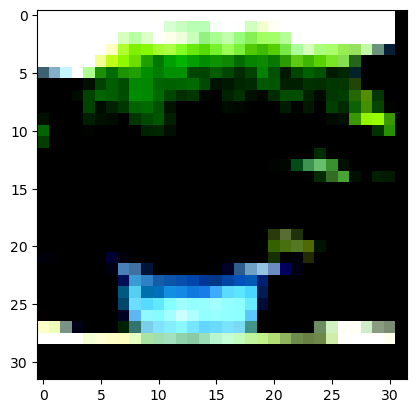

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


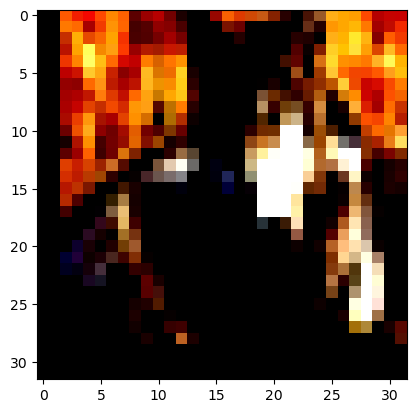

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


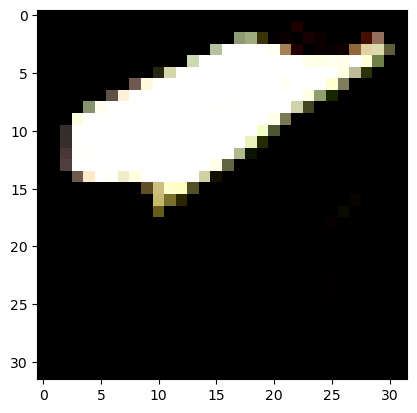

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


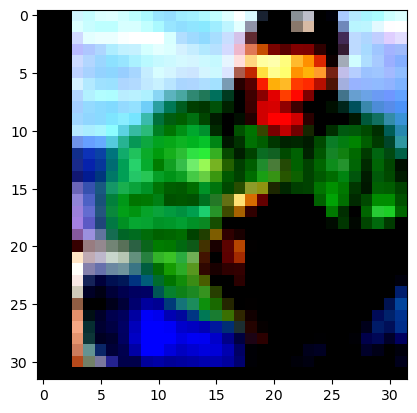

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


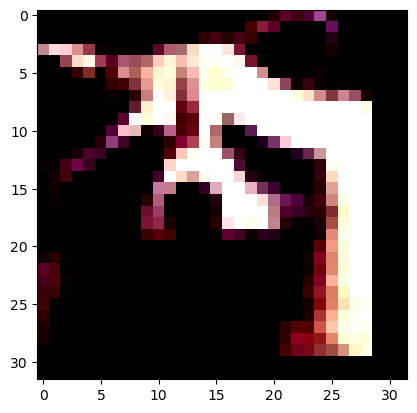

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


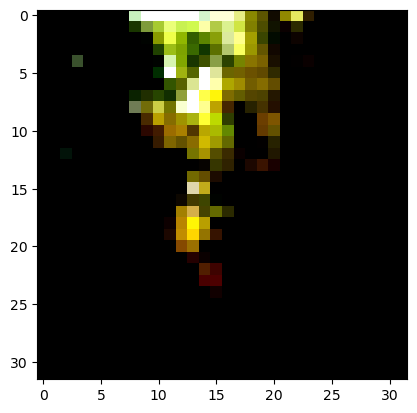

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


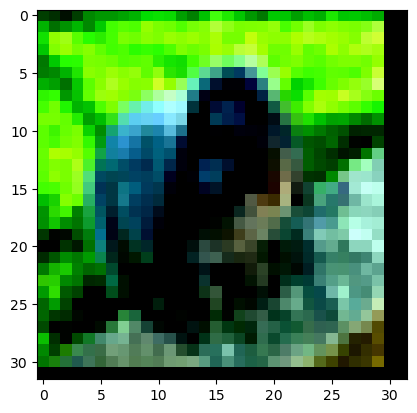

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


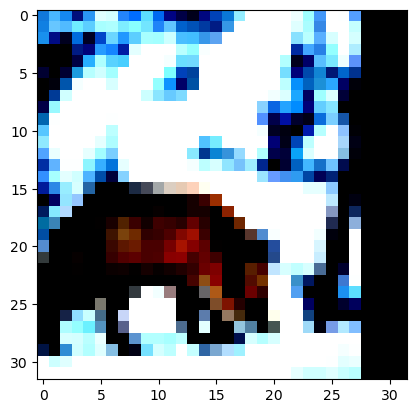

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


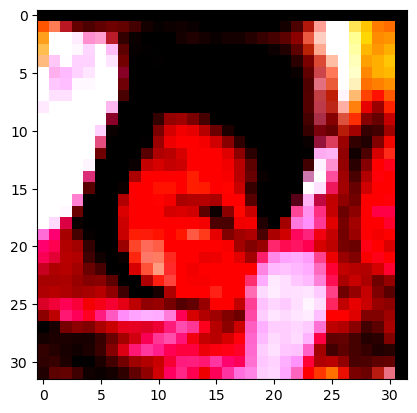

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


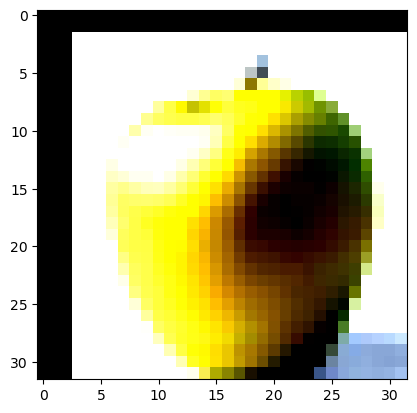

In [8]:
for experience in split_cifar100_with_valid.train_stream:
    # Show the first 4 images in the experience
    for sample in experience.dataset:
        plt.imshow(sample[0].permute(1, 2, 0))
        plt.show()
        break

## Train

In [9]:
from torchvision.models import resnet18
from torch.nn import CrossEntropyLoss
from avalanche.training import Naive

In [10]:
if torch.cuda.is_available():       
        device = torch.device("cuda")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [11]:
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger

In [12]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(trained_experience=True, stream=True, epoch_running=True),
    loss_metrics(stream=True, epoch_running=True, epoch=True),
    #forgetting_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger(), TextLogger(open('exploratory.txt', 'a')), TensorboardLogger()],
    strict_checks=False
)

In [13]:
from der import DerPlugin

In [14]:
lr = 0.02
mem_size = 500
alpha = 0.5
beta = 0.5
epochs = 50

In [15]:
model = resnet18(weights=None, num_classes=100)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = CrossEntropyLoss()

der_plugin = DerPlugin(mem_size=mem_size, alpha=alpha, beta=beta)

cl_strategy = Naive(model, optimizer, criterion, train_mb_size=64, train_epochs=epochs, eval_mb_size=64,
                    eval_every=1, device=device, evaluator=eval_plugin, plugins=[der_plugin])

Training loop

In [16]:
exp_results = []

In [17]:
# TRAINING LOOP WITH EVALUATION AT EACH EPOCH

print('Starting experiment...')
results = []
for experience in split_cifar100_with_valid.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    cl_strategy.train(experience)
    print('Training completed')

    exp_results.append(cl_strategy.eval(split_cifar100_with_valid.valid_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [96, 98, 42, 46, 78, 16, 24, 60, 62, 95]
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 71/71 [00:09<00:00,  7.57it/s]
> Eval on experience 0 (Task 0) from train stream ended.
-- >> End of eval phase << --
	Accuracy_On_Trained_Experiences/eval_phase/train_stream/Task000 = 0.0109
	Loss_Stream/eval_phase/train_stream/Task000 = 4.6731
	Top1_Acc_Stream/eval_phase/train_stream/Task000 = 0.0109
100%|██████████| 71/71 [00:04<00:00, 15.05it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.4144
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 7.4144
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.3713
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 71/71 [00:07<00:00,  9.74it/s]
> Eval on experience 0 (Task 0) from train stream ended.

### Get the accuracy on current and previous experiences

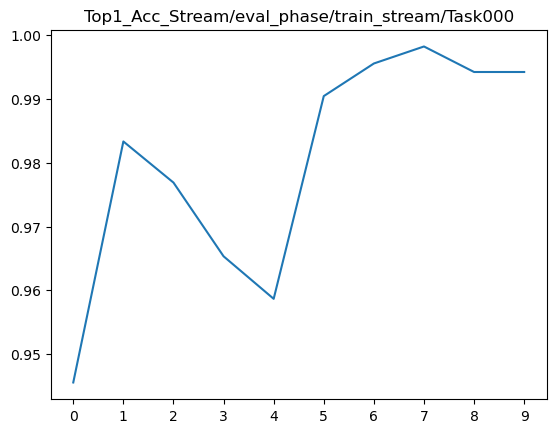

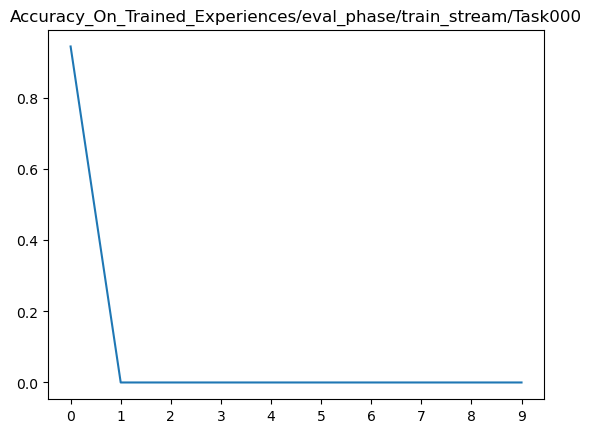

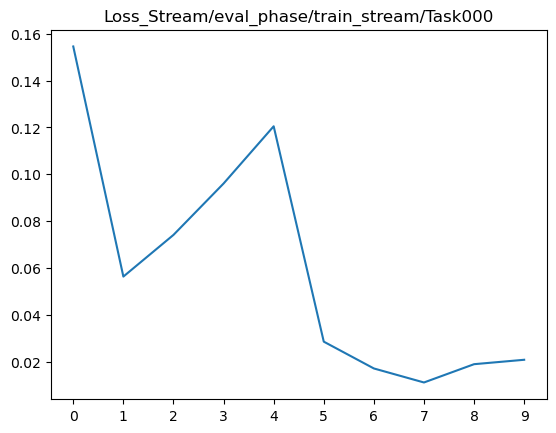

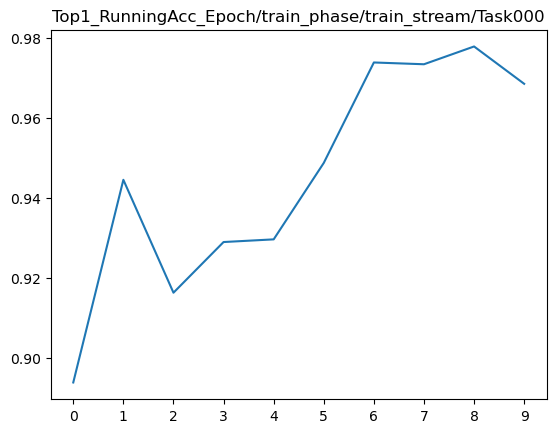

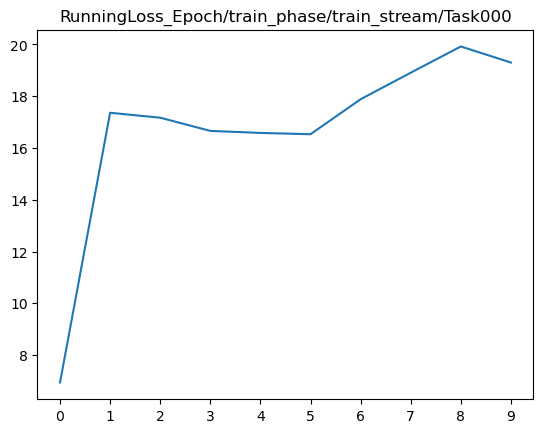

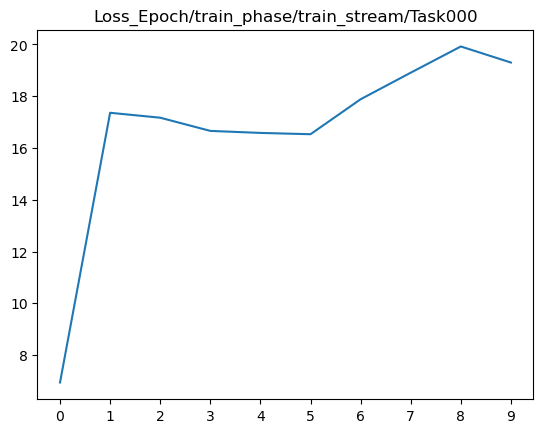

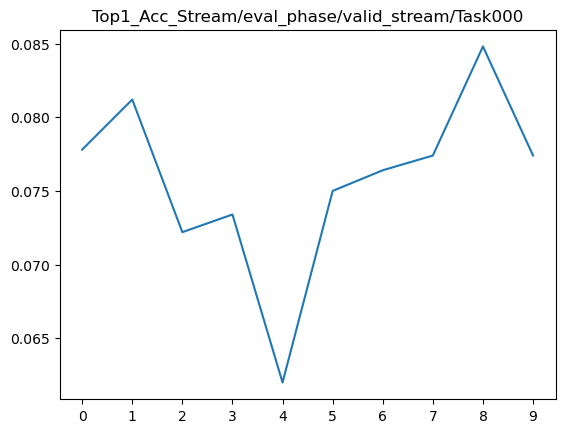

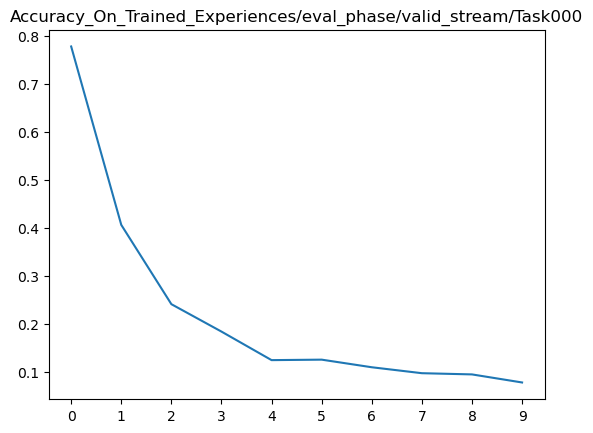

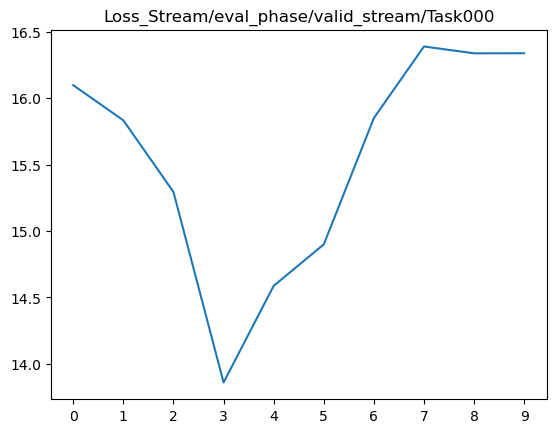

In [24]:
aggregated_results = {}

for i, exp_dict in enumerate(exp_results):
   for metric_name, metric_value in exp_dict.items():
        if metric_name not in aggregated_results:
            aggregated_results[metric_name] = []
            aggregated_results[metric_name].append(metric_value)
        else:
            aggregated_results[metric_name].append(metric_value)

for metric_name, metric_values in aggregated_results.items():
    plt.plot(metric_values, label=metric_name)
    plt.title(metric_name)
    plt.xticks(range(len(metric_values)))
    plt.show()

### Plot the loss curve for each experience

In [19]:
with open('exploratory.txt', 'r') as f:
# In the log file find all the lines starting with "Loss_Epoch"
    lines = [line for line in f.readlines() if line.startswith('\tLoss_Epoch')]
    # get the final loss at each line after the = sign
    epoch_losses_list = [float(line.split('=')[1]) for line in lines]
    

# Divide by experiences
exp_epoch_losses = [epoch_losses_list[i:i+epochs] for i in range(0, len(epoch_losses_list), epochs)]


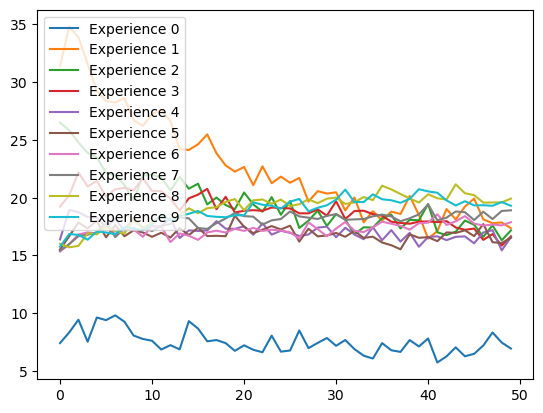

In [20]:
# Plot the loss for each experience
for i, exp_epoch_loss in enumerate(exp_epoch_losses):
    plt.plot(exp_epoch_loss, label=f'Experience {i}')
plt.legend()
plt.show()

### Check labels occurrences in the buffer are balanced

In [21]:
labels, occurrences = der_plugin.get_buffer_labels()
for label, occ in zip(labels, occurrences):
    print(f'Label: {label} - Occurrences: {occ}')

Label: 0 - Occurrences: 5
Label: 1 - Occurrences: 11
Label: 2 - Occurrences: 3
Label: 3 - Occurrences: 8
Label: 4 - Occurrences: 1
Label: 5 - Occurrences: 9
Label: 6 - Occurrences: 5
Label: 7 - Occurrences: 6
Label: 8 - Occurrences: 5
Label: 9 - Occurrences: 5
Label: 10 - Occurrences: 2
Label: 11 - Occurrences: 5
Label: 12 - Occurrences: 5
Label: 13 - Occurrences: 3
Label: 14 - Occurrences: 11
Label: 15 - Occurrences: 4
Label: 16 - Occurrences: 7
Label: 17 - Occurrences: 5
Label: 18 - Occurrences: 6
Label: 19 - Occurrences: 3
Label: 20 - Occurrences: 7
Label: 21 - Occurrences: 6
Label: 22 - Occurrences: 5
Label: 23 - Occurrences: 4
Label: 24 - Occurrences: 4
Label: 25 - Occurrences: 6
Label: 26 - Occurrences: 4
Label: 27 - Occurrences: 4
Label: 28 - Occurrences: 5
Label: 29 - Occurrences: 5
Label: 30 - Occurrences: 4
Label: 31 - Occurrences: 3
Label: 32 - Occurrences: 5
Label: 33 - Occurrences: 3
Label: 34 - Occurrences: 5
Label: 35 - Occurrences: 5
Label: 36 - Occurrences: 7
Label: 37

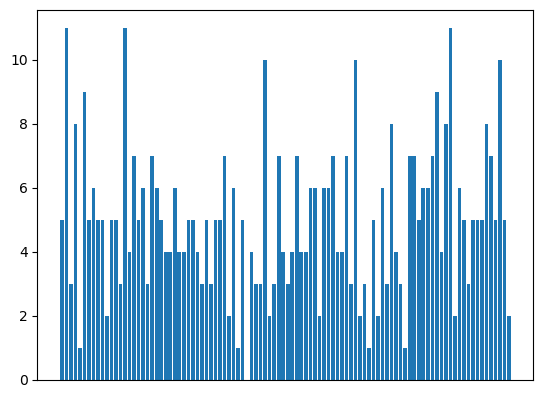

In [22]:
# make bar plot of the occurrences, with no xaxis label
plt.bar(labels, occurrences)
plt.xticks([])
plt.show()
